## In this session

- How to build a traditional model?
- How to improve model performance?
- What are the drawbacks of 'simple' performance improvement?

### Topics covered
- Linear regression
- RMSE as a measure of fit
- Overfitting

## Linear Regression

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
filename = 'used_cars.csv'

In [4]:
filepath = os.path.join('datasets', filename)
filepath

'datasets\\used_cars.csv'

In [5]:
df = pd.read_csv(filepath)

In [7]:
df

,price,lnprice,area,chicago,age,agesq,agecu,odometer,odometersq,dealer,LE,XLE,SE,cond_excellent,cond_good,cond_likenew,cylind6
0,14850,9.605755,chicago,1,3,9,27,3.572100,12.759898,1,0,0,0,1,0,0,0
1,15630,9.656947,chicago,1,2,4,8,1.315200,1.729751,1,0,0,0,0,0,0,0
2,850,6.745236,chicago,1,25,625,15625,18.700000,349.690000,0,0,0,0,0,1,0,1
3,1600,7.377759,chicago,1,20,400,8000,16.824259,283.055684,0,1,0,0,0,0,0,0
4,1500,7.313220,chicago,1,20,400,8000,16.824259,283.055684,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,1500,7.313220,los angeles,0,17,289,4913,27.000000,729.000000,0,0,0,0,1,0,0,1
474,6800,8.824677,los angeles,0,6,36,216,8.304974,68.972587,0,0,0,1,1,0,0,0
475,2000,7.600903,los angeles,0,10,100,1000,12.548112,157.455113,0,0,0,0,0,0,0,0
476,2700,7.901007,los angeles,0,16,256,4096,16.100000,259.210000,0,0,0,0,1,0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           478 non-null    int64  
 1   lnprice         478 non-null    float64
 2   area            478 non-null    object 
 3   chicago         478 non-null    int64  
 4   age             478 non-null    int64  
 5   agesq           478 non-null    int64  
 6   agecu           478 non-null    int64  
 7   odometer        478 non-null    float64
 8   odometersq      478 non-null    float64
 9   dealer          478 non-null    int64  
 10  LE              478 non-null    int64  
 11  XLE             478 non-null    int64  
 12  SE              478 non-null    int64  
 13  cond_excellent  478 non-null    int64  
 14  cond_good       478 non-null    int64  
 15  cond_likenew    478 non-null    int64  
 16  cylind6         478 non-null    int64  
dtypes: float64(3), int64(13), object(1)

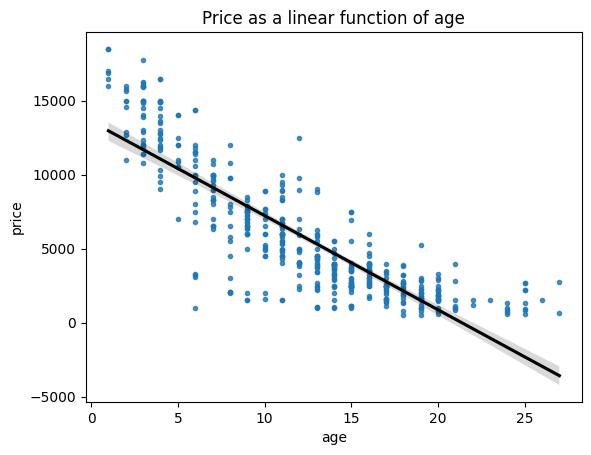

In [9]:
sns.regplot(
    data = df,
    x = 'age', y = 'price',
    marker = '.',
    fit_reg = True, 
    line_kws= {'color': 'k'}
)
plt.title('Price as a linear function of age');

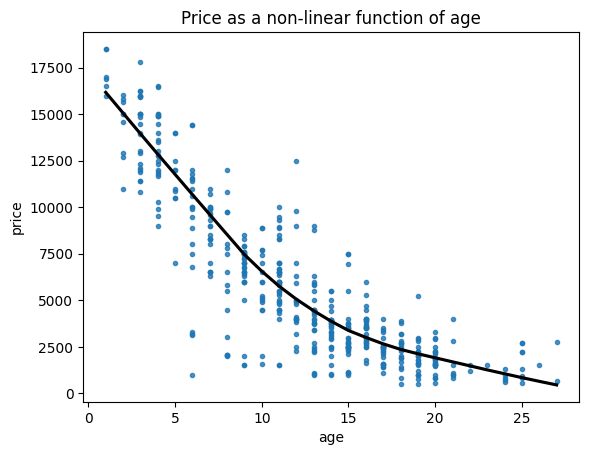

In [10]:
sns.regplot(
    data = df,
    x = 'age', y = 'price',
    marker = '.',
    fit_reg = True, lowess = True,
    line_kws= {'color': 'k'}
)
plt.title('Price as a non-linear function of age');

In [11]:
df.groupby('area')['price'].count()

area
chicago        281
los angeles    197
Name: price, dtype: int64

In [12]:
df_chicago = df[df.chicago == 1]
df_la = df[df.chicago == 0]

In [13]:
df_la.sort_values(by = 'age', inplace= True)

### Build a Model - A Traditional Approach

In the traditional approach we are defining a set of `explanatory variables`, which we think are related to the development of our `target variable`. The model assumes a `linear relationship` between the target variable $y$ and the explanatory variables. 

<center>
    $y_i = \beta_0 + \beta_1x_i + \epsilon_i$
</center>
<br>where $\beta_0$ is a constant, and $\epsilon$ is a normally distributed random number with an expected value of 0: 
<br>
<br>
<center>
    $\epsilon \sim N(0,\sigma_{\epsilon})$.
</center>
<br>
(Note: standard normal distribution is $N(0, 1)$)

<br>The - almost oversimplifed -  interpretation of the parameters are:
- $\beta_0$: the expected value of $y$ if $x$ = 0 (can be meaningless) 
- $\beta_1$: expected **unit change** in $y$ if $x$ is **one unit higher**, each measured in their own units.

A regression model is meaningful if
- the model explains a fair amount from the variability of the dependent ($y$) variable; we measure it with $R^2$ 
- if the $\beta_1$, $\beta_2$, ... variables are significantly different from zero; we measure it with the _t_statistics_ and the corresponding _p_values_
- the model overall _F-stastistic_ is high and its corresponding _p_value_ is low. 

#### How to build a traditional model in Python?

1. Define your exact model as a formula.
2. Instantiate a regression object.
3. Fit the regression to your data
4. Analyze results
5. Compare your model to other options.
6. Make prediction.

1. **Define your formula**
<center>
    $price_i = \beta_0 + \beta_1age_i + \epsilon_i$
</center>

<br>   

2. **Instantiate a model object**

In [14]:
simple_model = smf.ols("price ~ age", data=df_chicago)

In [ ]:
type(simple_model)

3. **Fit the regression to your data**

In [15]:
simple_model_fitted = simple_model.fit(cov_type= 'HC1')

In [ ]:
type(simple_model_fitted)

4. **Analyze results**

In [16]:
print(simple_model_fitted.get_robustcov_results().summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     628.9
Date:                Thu, 23 May 2024   Prob (F-statistic):           1.89e-73
Time:                        15:23:04   Log-Likelihood:                -2562.0
No. Observations:                 281   AIC:                             5128.
Df Residuals:                     279   BIC:                             5135.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.422e+04    377.431     37.683      0.0

In [ ]:
print('R2 = {:.2%}'.format(simple_model_fitted.get_robustcov_results().rsquared))

In [17]:
fitted_values_chicago = simple_model_fitted.get_robustcov_results().fittedvalues

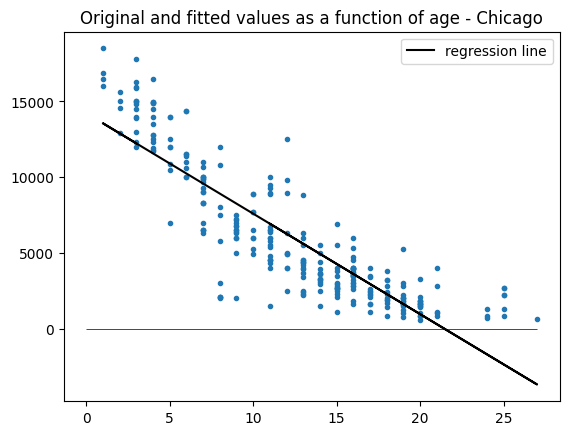

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x = df_chicago.age, y = df_chicago.price, marker = '.')
ax.plot( df_chicago.age, fitted_values_chicago, color = 'k', label = 'regression line')
ax.hlines( 0, 0, df_chicago.age.max(), color = 'k', linewidth = 0.5)
plt.title('Original and fitted values as a function of age - Chicago')
plt.legend();

#### External validity

`External validity` is concept related to the behavior of the model on data which it has not seen. If we train the model Chicago, will it properly predict data for cars in Los Angeles?

In [19]:
fitted_values_la = simple_model_fitted.predict(df_la)

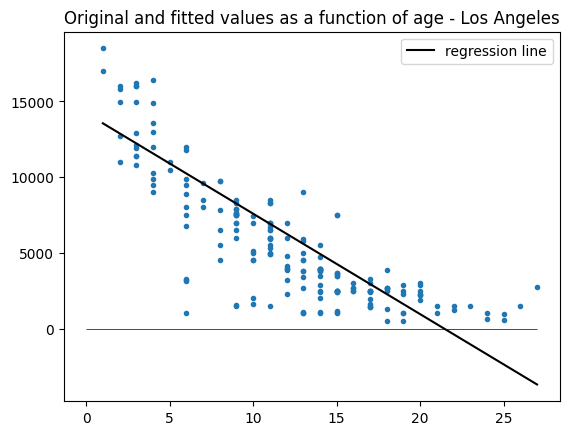

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x = df_la.age, y = df_la.price, marker = '.')
ax.plot(df_la.age, fitted_values_la, color = 'k', label = 'regression line')
ax.hlines( 0, 0, df_la.age.max(), color = 'k', linewidth = 0.5)
plt.title('Original and fitted values as a function of age - Los Angeles')
plt.legend();

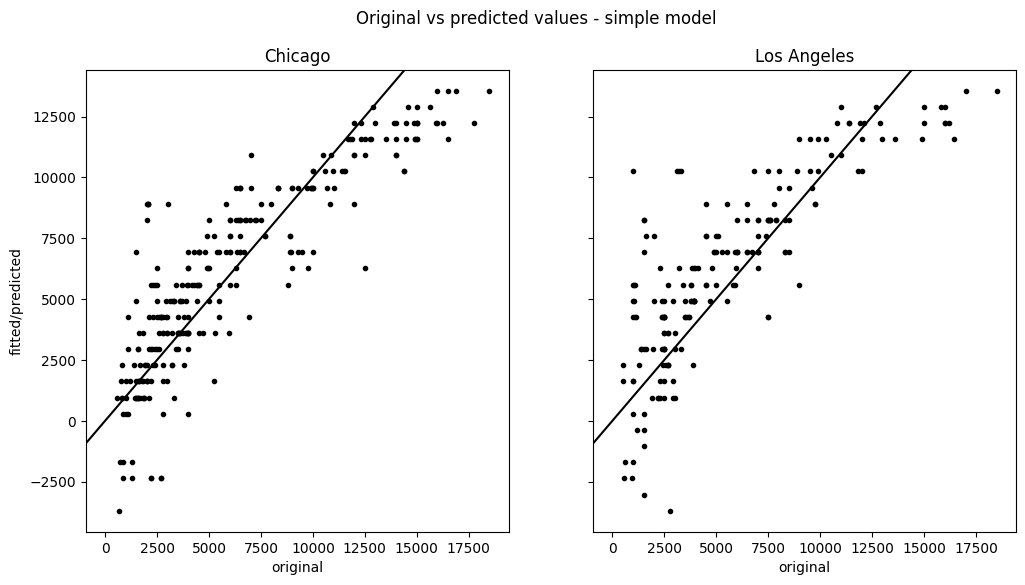

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (12,6))
axs[0].scatter(x = df_chicago.price, y = fitted_values_chicago, marker = '.', color = 'black')
axs[0].axline([0, 0], [1, 1], color = 'k')
axs[0].set_title('Chicago')
axs[1].scatter(x = df_la.price, y = fitted_values_la, marker = '.', color = 'k')
axs[1].axline([0, 0], [1, 1], color = 'k')
axs[1].set_title('Los Angeles')
fig.suptitle('Original vs predicted values - simple model')

for ax in axs.flat:
    ax.set(xlabel='original', ylabel='fitted/predicted')

for ax in axs.flat:
    ax.label_outer()

#### Measures of fit

We need to compare predicted values with original values. In order to punish large misses in prediction we take the average of the *squared differences* between the original and the predicted data. To make it comparable with the  original values we take square root of this average. 

This measure is of primary importance in modelling tabular data, and we call it `root mean squared error`, or `RMSE`.
$$
RMSE = \sqrt{\frac{ \sum_{i=1}^{n} (y_i - \hat{y_i})^2}{n}}
$$
<br>

where $y_i$ is the original value and $\hat{y_i}$ is the predicted value.

In [22]:
rmse_chicago = mean_squared_error(df_chicago.price, fitted_values_chicago, squared= False)
rmse_la = mean_squared_error(df_la.price, fitted_values_la, squared= False)

print('RMSE Chicago: {:,.2f}.'.format(rmse_chicago))
print('RMSE Los Angeles: {:,.2f}.'.format(rmse_la))

RMSE Chicago: 2,204.82.
RMSE Los Angeles: 2,453.12.


In [23]:
print('RMSE ratio between Los Angeles & Chicago: {:.3f}'.format(rmse_la / rmse_chicago))

RMSE ratio between Los Angeles & Chicago: 1.113


#### Improving model fit: increase the complexity of the model

A more complex model can find more nuanced patterns in our data. Model complexity can be increased through
- more variables
- transformed variables
- interactions between variables

Since the relationship between price and age are clearly not linear, we can add non-linear terms to our model, for instance the square of age, thereby creating a so-called `polinomial model`. 

<center>
    $price_i = \beta_0 + \beta_1age_i + \beta_2age_i^2 + \epsilon_i$
</center>

In [24]:
polinomial_model = smf.ols("price ~ age + agesq", data=df_chicago)
polinomial_model_fitted = polinomial_model.fit(cov_type= 'HC1')
polinom_fitted_values_chicago = polinomial_model_fitted.get_robustcov_results().fittedvalues
polinom_fitted_values_la = polinomial_model_fitted.predict(df_la)

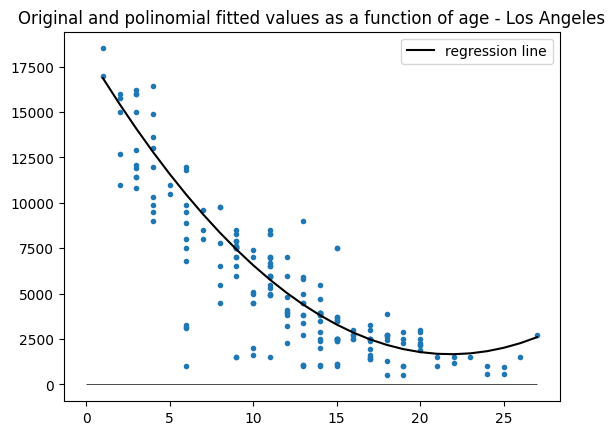

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x = df_la.age, y = df_la.price, marker = '.')
ax.plot(df_la.age, polinom_fitted_values_la,   color = 'k', label = 'regression line')
ax.hlines( 0, 0, df_la.age.max(), color = 'k', linewidth = 0.5)
plt.title('Original and polinomial fitted values as a function of age - Los Angeles')
plt.legend();

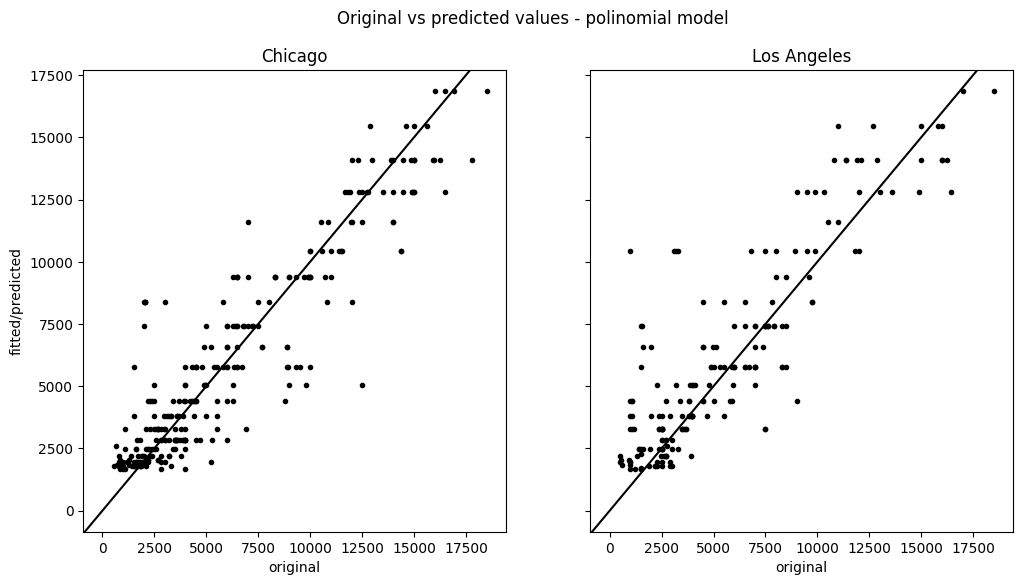

In [26]:
fig, axs = plt.subplots(1, 2, figsize = (12,6))
axs[0].scatter(x = df_chicago.price, y = polinom_fitted_values_chicago, marker = '.', color = 'black')
axs[0].axline([0, 0], [1, 1], color = 'k')
axs[0].set_title('Chicago')
axs[1].scatter(x = df_la.price, y = polinom_fitted_values_la, marker = '.', color = 'k')
axs[1].axline([0, 0], [1, 1], color = 'k')
axs[1].set_title('Los Angeles')
fig.suptitle('Original vs predicted values - polinomial model')

for ax in axs.flat:
    ax.set(xlabel='original', ylabel='fitted/predicted')

for ax in axs.flat:
    ax.label_outer()

In [27]:
polinomial_rmse_chicago = mean_squared_error(df_chicago.price, polinom_fitted_values_chicago, squared= False)
polinomial_rmse_la = mean_squared_error(df_la.price, polinom_fitted_values_la, squared= False)

print('RMSE Chicago: {:,.2f}.'.format(polinomial_rmse_chicago))
print('RMSE Los Angeles: {:,.2f}.'.format(polinomial_rmse_la))

RMSE Chicago: 1,755.18.
RMSE Los Angeles: 2,058.08.


In [28]:
print('RMSE ratio between Los Angeles & Chicago: {:.3f}'.format(polinomial_rmse_la / polinomial_rmse_chicago))

RMSE ratio between Los Angeles & Chicago: 1.173


<br>
While prediction error (RMSE) improved, it improved more for Chicago - where the model was trained. Perdiction error improved more modestly for the unseen dataset.
<br>
<br>

When we increase model complexity, we get a better fit, but sometimes only for the training data. We call it **overfitting**: our model will be superior for the training dataset but may be completely misleading for another *test* dataset.

`scikit-learn` is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection, model evaluation, and many other utilities.

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

#### A super complex model with all possible variations and combinations

In [30]:
super_model = smf.ols(
    "price ~ age + agesq + odometer + dealer + odometersq + LE*age + XLE*age + SE*age + cond_likenew*age + cond_excellent*age + cond_good*age + cylind6*age + odometer*age + dealer*age", 
    data = df_chicago)
super_model_fitted = super_model.fit(cov_type= 'HC1')
super_fitted_values_chicago = super_model_fitted.get_robustcov_results().fittedvalues
super_fitted_values_la = super_model_fitted.predict(df_la)

In [31]:
super_rmse_chicago = mean_squared_error(df_chicago.price, super_fitted_values_chicago, squared= False)
super_rmse_la = mean_squared_error(df_la.price, super_fitted_values_la, squared= False)
print('RMSE Chicago: {:,.2f}.'.format(super_rmse_chicago))
print('RMSE Los Angeles: {:,.2f}.'.format(super_rmse_la))

RMSE Chicago: 1,241.32.
RMSE Los Angeles: 1,960.34.


In [ ]:
print('RMSE ratio between Los Angeles & Chicago: {:.3f}'.format(super_rmse_la / super_rmse_chicago))

```text
RMSE has improved meaningfully for Chicago but only slightly for Los Angeles (the unseen data). We are overfitting our model on the training data by using and overly complex model. 
```

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12,6))
axs[0].scatter(x = df_chicago.price, y = super_fitted_values_chicago, marker = '.', color = 'black')
axs[0].axline([0, 0], [1, 1], color = 'k')
axs[0].set_title('Chicago')
axs[1].scatter(x = df_la.price, y = super_fitted_values_la, marker = '.', color = 'k')
axs[1].axline([0, 0], [1, 1], color = 'k')
axs[1].set_title('Los Angeles')
fig.suptitle('Original vs predicted values')

for ax in axs.flat:
    ax.set(xlabel='original', ylabel='fitted/predicted')

for ax in axs.flat:
    ax.label_outer()

As a reminder:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12,6))
axs[0].scatter(x = df_chicago.price, y = polinom_fitted_values_chicago, marker = '.', color = 'black')
axs[0].axline([0, 0], [1, 1], color = 'k')
axs[0].set_title('Chicago')
axs[1].scatter(x = df_la.price, y = polinom_fitted_values_la, marker = '.', color = 'k')
axs[1].axline([0, 0], [1, 1], color = 'k')
axs[1].set_title('Los Angeles')
fig.suptitle('Original vs predicted values - polinomial model')

for ax in axs.flat:
    ax.set(xlabel='original', ylabel='fitted/predicted')

for ax in axs.flat:
    ax.label_outer()